## Cyberbullying Detection: A Machine Learning Approach

In [1]:
#imports

import pandas as pd 
import nltk
import re
import matplotlib.pyplot as plt
import numpy as np
import sklearn

### Step 1: Load the Dataset 

In [2]:
#load the cleaned table into df
# need to adjust the index numbers manually because it is not arranged properly and it is renamed into the same filename
# However a new file called cleaned_table_final_rearranged was created later for the final program
# so that the user dont have to manually change the index number in the file 

data = pd.read_csv("cleaned_table.csv")

#### Define full data and partial data 

In [3]:
# using partial data because not enough memory
# using 50% of the full dataset
x_partial = data['cleaned_tweet'][0:17424] #feature
y_partial = data['target'][0:17424] #target

In [4]:
print(x_partial.shape)
print(y_partial.shape)

(17424,)
(17424,)


In [5]:
#using all data
x = data['cleaned_tweet'] #feature
y = data['target'] #target

In [6]:
print(x.shape)
print(y.shape)

(34848,)
(34848,)


#### Split the data into train data and test data (full data)

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
# split data 

x_train, x_test, y_train_label, y_test_label = train_test_split(x, y, test_size=0.2, random_state = 42)

print("x_train shape {} , x_test shape {} ".format(x_train.shape, x_test.shape))
print("y_train shape {} , y_test shape {} ".format(y_train_label.shape, y_test_label.shape))

x_train shape (27878,) , x_test shape (6970,) 
y_train shape (27878,) , y_test shape (6970,) 


#### Split data for Bag of Words (partial data)

In [9]:
# split data for bow 

x_train_bow_p, x_test_bow_p, y_train_label_bow_p, y_test_label_bow_p = train_test_split(x_partial, y_partial, test_size=0.2, random_state = 42)

print("Partial data: ")
print("x_train_bow_p shape for BOW {} , x_test_bow_p shape for BOW {} ".format(x_train_bow_p.shape, x_test_bow_p.shape))
print("y_train_label_bow_p shape for BOW {} , y_test_label_bow_p shape for BOW {} ".format(y_train_label_bow_p.shape, y_test_label_bow_p.shape))

Partial data: 
x_train_bow_p shape for BOW (13939,) , x_test_bow_p shape for BOW (3485,) 
y_train_label_bow_p shape for BOW (13939,) , y_test_label_bow_p shape for BOW (3485,) 


In [10]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.remove('not')
stop_words.extend(['rt', 'mkr', 'httpâ', 'tvwâ', 'etc'])

In [11]:
# for creating train data (bow_x_train) and test data (bow_x_test)
# base performance 

print("Bag of Words……")

from sklearn.feature_extraction.text import CountVectorizer

my_stopWords = stop_words
count_vectorizer = CountVectorizer(stop_words= my_stopWords)
bow_vector_p = count_vectorizer.fit(x_train_bow_p)
bow_x_train_p = count_vectorizer.transform(x_train_bow_p)

bow_x_test_p = count_vectorizer.transform(x_test_bow_p)

Bag of Words……


#### Split data for Bag of Words (full data)

In [12]:
# split data for bow 

x_train_bow, x_test_bow, y_train_label_bow, y_test_label_bow = train_test_split(x, y, test_size=0.2, random_state = 42)

print("Full data: ")
print("x_train_bow shape for BOW {} , x_test_bow shape for BOW {} ".format(x_train_bow.shape, x_test_bow.shape))
print("y_train_bow shape for BOW {} , y_test_bow shape for BOW {} ".format(y_train_label_bow.shape, y_test_label_bow.shape))

Full data: 
x_train_bow shape for BOW (27878,) , x_test_bow shape for BOW (6970,) 
y_train_bow shape for BOW (27878,) , y_test_bow shape for BOW (6970,) 


In [13]:
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.remove('not')
stop_words.extend(['rt', 'mkr', 'httpâ', 'tvwâ', 'etc'])

In [14]:
# for creating train data (bow_x_train) and test data (bow_x_test)
# base performance 
# will use pipeline to find the best parameters of bow when a suitable algorithm is selected

print("Bag of Words……")

from sklearn.feature_extraction.text import CountVectorizer

my_stopWords = stop_words
count_vectorizer = CountVectorizer(stop_words= my_stopWords)
bow_vector = count_vectorizer.fit(x_train_bow)
bow_x_train = count_vectorizer.transform(x_train_bow)

bow_x_test = count_vectorizer.transform(x_test_bow)

Bag of Words……


#### All models (Bag of Words)

#### Train the model 

In [144]:
# just use kfold since it has balanced target classes
# set the settings for machine learning algorithm as default first, 
# then pick the 2 best algorithm that has the highest accuracy, high recall for positive class and f1 -score

# to do kfold validation
from sklearn import model_selection
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

# to evaluate the results of the models
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict

# to find the best parameter
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config

# prepare configuration for cross validation test harness
seed = 7

# prepare models
models = []
models.append(('MNB', MultinomialNB()))
models.append(('SVM', svm.SVC(random_state = 42, probability=True)))
models.append(('DTC', DecisionTreeClassifier(splitter='random', random_state=42)))
models.append(('RFC', RandomForestClassifier(random_state = 42)))


results = []
names = []
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}


In [16]:
# perform 10 kfold validation on validation set 
# use partial data because full data takes a long time to do it 

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = model_selection.cross_validate(model, bow_x_train_p, y_train_label_bow_p, scoring=scoring, cv=kfold)
    
    results.append(cv_results)
    names.append(name)
    accuracy = "%s: %f (%f)" % (name, np.mean(cv_results['test_accuracy']), np.mean(cv_results['test_accuracy'].std()))
    print("Validation Accuracy")
    print(accuracy)
    print("\n")
    
    precision = "%s: %f (%f)" % (name, np.mean(cv_results['test_precision']), np.mean(cv_results['test_precision'].std()))
    print("Validation Precision")
    print(precision)
    print("\n")
    
    recall = "%s: %f (%f)" % (name, np.mean(cv_results['test_recall']), np.mean(cv_results['test_recall'].std()))
    print("Validation Recall")
    print(recall)
    print("\n")
    
    recall = "%s: %f (%f)" % (name, np.mean(cv_results['test_f1_score']), np.mean(cv_results['test_f1_score'].std()))
    print("Validation F1 Score")
    print(recall)
    
    print("\n")
    print("\n")

Validation Accuracy
MNB: 0.803788 (0.008592)


Validation Precision
MNB: 0.784746 (0.013100)


Validation Recall
MNB: 0.805632 (0.017482)


Validation F1 Score
MNB: 0.794913 (0.011145)




Validation Accuracy
SVM: 0.880766 (0.011660)


Validation Precision
SVM: 0.907295 (0.013680)


Validation Recall
SVM: 0.832707 (0.020216)


Validation F1 Score
SVM: 0.868263 (0.013794)




Validation Accuracy
DTC: 0.853003 (0.010048)


Validation Precision
DTC: 0.841363 (0.018510)


Validation Recall
DTC: 0.849026 (0.012950)


Validation F1 Score
DTC: 0.845033 (0.011615)




Validation Accuracy
RFC: 0.868211 (0.008806)


Validation Precision
RFC: 0.882343 (0.013964)


Validation Recall
RFC: 0.832087 (0.014974)


Validation F1 Score
RFC: 0.856352 (0.010239)






MNB


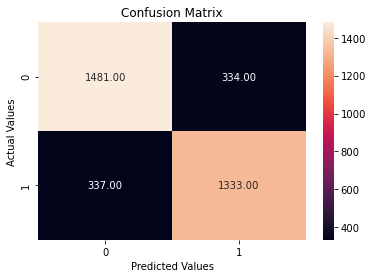

SVM


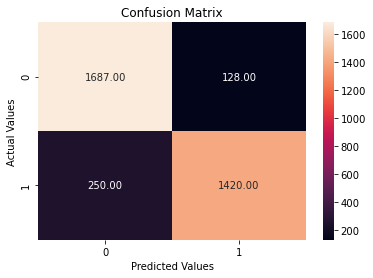

DTC


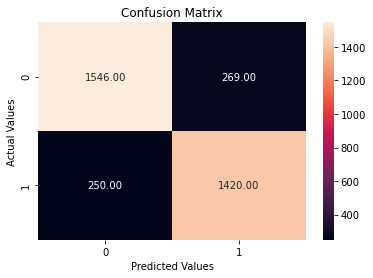

RFC


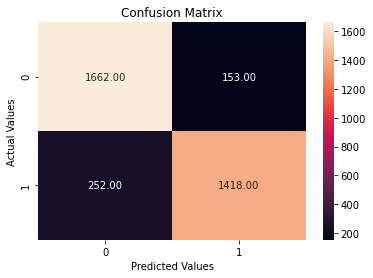

In [17]:
# plot the confusion matrix for 2 best
# see which one has lesser false negative

# 1 - cyberbullying 
# 0 - non-cyberbullying

# TP (11) - cyberbullying class
# TN (00) - non-cyberbullying class

for name, model in models:
    model.fit(bow_x_train_p, y_train_label_bow_p)
    model_predicted = model.predict(bow_x_test_p)
    cm = confusion_matrix(y_test_label_bow_p, model_predicted)
    print(name)
    sns.heatmap(cm, annot=True, fmt = '.2f')
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Values')
    plt.xlabel('Predicted Values')
    plt.show()

#### Train the model again after choosing the algorithm

Support Vector Machine
0.9097560975609756
              precision    recall  f1-score   support

           0       0.88      0.93      0.91      3245
           1       0.94      0.89      0.91      3725

    accuracy                           0.91      6970
   macro avg       0.91      0.91      0.91      6970
weighted avg       0.91      0.91      0.91      6970



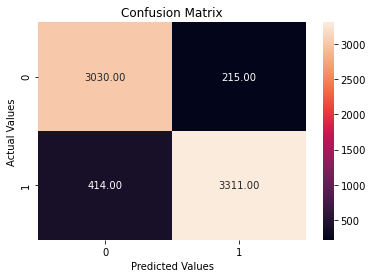

In [18]:
# SVM and RFC was compared and it shows that SVM has lesser FN and higher TP
# SVM chosen as final machine learning algorithm
# retrain the SVM model again to set it as base model because it has lesser false negatives 
# results: classification report, accuracy score, confusion matrix

base_model = svm.SVC(random_state = 42, probability=True)
base_model = sklearn.base.clone(base_model)

base_model.fit(bow_x_train, y_train_label_bow)
base_model_predicted = base_model.predict(bow_x_test)
print("Support Vector Machine")
print(accuracy_score(y_test_label_bow, base_model_predicted))
print(classification_report(y_test_label_bow, base_model_predicted))

base_cm = confusion_matrix(y_test_label_bow, base_model_predicted)
sns.heatmap(base_cm, annot=True, fmt = '.2f')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [161]:
# Precision vs Recall Graph of Base Model

# retrieve the average cross-validated prediction score values for all samples 
base_model_bow_score_cv = cross_val_predict(base_model, bow_x_test, y_test_label_bow, cv = 3, method = "decision_function")
base_model_bow_score_cv

array([-1.57773608, -1.30990364,  0.49250121, ..., -0.29690581,
       -0.2624392 , -0.30598664])

<Figure size 432x288 with 0 Axes>

<Figure size 576x432 with 0 Axes>

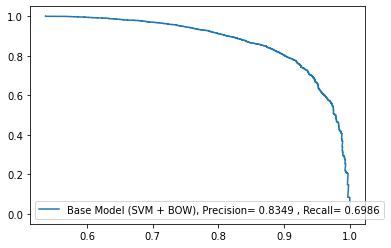

In [182]:
from sklearn.metrics import precision_recall_curve

plt.figure(0).clf()

base_model_bow_precision, base_model_bow_recall, base_model_bow_threhold = precision_recall_curve(
                                                                            y_test_label_bow, base_model_bow_score_cv)

precision_base = round(np.mean(base_model_bow_precision),4)
recall_base = round(np.mean(base_model_bow_recall),4)
threshold_base = round(np.mean(base_model_bow_threhold),4)

plt.figure(figsize=(8, 6))
plt.show()
plt.plot(base_model_bow_precision, base_model_bow_recall ,
         label="Base Model (SVM + BOW), Precision= {} , Recall= {}".format(str(precision_base), str(recall_base)))
plt.legend()

In [183]:
# threshold of base model
print(threshold_base)

0.1202


In [190]:
# calculate Cohen Kappa score and Matthews Correlation Coefficient (MCC)

from sklearn.metrics import cohen_kappa_score
ckappa_score_base_bow = cohen_kappa_score(y_test_label_bow, base_model_predicted)
print("Kappa score for base model (BOW) : ", round(ckappa_score_base_bow, 4))

from sklearn.metrics import matthews_corrcoef
mcc_score_base_bow = matthews_corrcoef(y_test_label_bow, base_model_predicted)
print("MCC score for base model (BOW) : ", round(mcc_score_base_bow,4))

Kappa score for base model (BOW) :  0.8194
MCC score for base model (BOW) :  0.8207


In [20]:
# need to fine tune the base model to get better results 
# by adjusting the regularization C value, it can be seen it improves the accuracy of the model
# using grid search to find the best parameter for SVM
  
# set the range for parameters
parameter_gs_bow = {'C': [0.01, 0.1, 1, 10, 100, 1000], 
              'kernel': ['linear']} 
  
gs_bow = GridSearchCV(svm.SVC(), parameter_gs_bow, refit = True, verbose = 3)
  
# fitting the model for grid search
gs_bow.fit(bow_x_train, y_train_label_bow)


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ..........................C=0.01, kernel=linear; total time=  52.1s
[CV 2/5] END ..........................C=0.01, kernel=linear; total time=  50.6s
[CV 3/5] END ..........................C=0.01, kernel=linear; total time=  51.1s
[CV 4/5] END ..........................C=0.01, kernel=linear; total time=  52.9s
[CV 5/5] END ..........................C=0.01, kernel=linear; total time=  51.5s
[CV 1/5] END ...........................C=0.1, kernel=linear; total time= 1.2min
[CV 2/5] END ...........................C=0.1, kernel=linear; total time= 1.0min
[CV 3/5] END ...........................C=0.1, kernel=linear; total time= 1.0min
[CV 4/5] END ...........................C=0.1, kernel=linear; total time= 1.2min
[CV 5/5] END ...........................C=0.1, kernel=linear; total time= 1.1min
[CV 1/5] END .............................C=1, kernel=linear; total time= 1.7min
[CV 2/5] END .............................C=1, ke

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'kernel': ['linear']},
             verbose=3)

In [21]:
# print best parameter after tuning
print(gs_bow.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(gs_bow.best_estimator_)

{'C': 0.1, 'kernel': 'linear'}
SVC(C=0.1, kernel='linear')


              precision    recall  f1-score   support

           0       0.91      0.94      0.92      3245
           1       0.94      0.92      0.93      3725

    accuracy                           0.93      6970
   macro avg       0.93      0.93      0.93      6970
weighted avg       0.93      0.93      0.93      6970



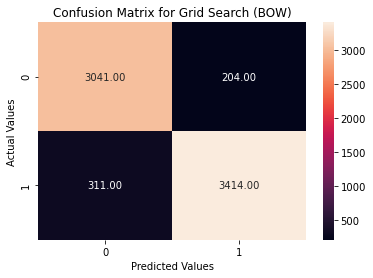

In [123]:
# grid search model (BOW)
predictions_gs_bow = gs_bow.predict(bow_x_test)

# print classification report
print(classification_report(y_test_label_bow, predictions_gs_bow))

# print confusion matrix
gs_cm_bow = confusion_matrix(y_test_label_bow, predictions_gs_bow)
sns.heatmap(gs_cm_bow, annot=True, fmt = '.2f')
plt.title('Confusion Matrix for Grid Search (BOW)')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

              precision    recall  f1-score   support

           0       0.88      0.93      0.91      3245
           1       0.94      0.89      0.91      3725

    accuracy                           0.91      6970
   macro avg       0.91      0.91      0.91      6970
weighted avg       0.91      0.91      0.91      6970



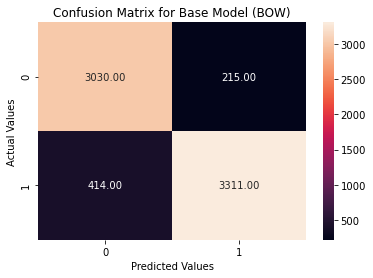

In [126]:
# baseline model (BOW)

# print classification report
print(classification_report(y_test_label_bow, base_model_predicted))

# print confusion matrix 
sns.heatmap(base_cm, annot=True, fmt = '.2f')
plt.title('Confusion Matrix for Base Model (BOW)')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

#### TFIDF (to see if it is better than bow)

In [23]:
# split data for tfidf (full data)
# no need to train with 10 fold because the machine learning algorithm is chosen

x_train_tfidf, x_test_tfidf, y_train_label_tfidf, y_test_label_tfidf = train_test_split(x, y, test_size=0.2, random_state = 42)

print("x_train_tfidf shape for TFIDF {} , x_test_tfidf shape for TFIDF {} ".format(x_train_tfidf.shape, x_test_tfidf.shape))
print("y_train_tfidf shape for TFIDF {} , y_test_tfidf shape for TFIDF {} ".format(y_train_label_tfidf.shape, y_test_label_tfidf.shape))

x_train_tfidf shape for TFIDF (27878,) , x_test_tfidf shape for TFIDF (6970,) 
y_train_tfidf shape for TFIDF (27878,) , y_test_tfidf shape for TFIDF (6970,) 


In [24]:
# default settings 

print("TFIDF Vectorizer……")

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer= TfidfVectorizer()
tf_train_vector = vectorizer.fit(x_train_tfidf)
tf_x_train = vectorizer.transform(x_train_tfidf)

tf_x_test = vectorizer.transform(x_test_tfidf)

TFIDF Vectorizer……


In [119]:
# retrain the SVM model again to set it as base model for tfidf
# results: classification report, accuracy score, confusion matrix

base_model_tfidf = svm.SVC(random_state = 42, probability=True)
base_model_tfidf = sklearn.base.clone(base_model_tfidf)

base_model_tfidf.fit(tf_x_train, y_train_label_tfidf)
base_model_predicted_tfidf = base_model_tfidf.predict(tf_x_test)

Support Vector Machine
0.9164992826398852
              precision    recall  f1-score   support

           0       0.89      0.94      0.91      3245
           1       0.94      0.90      0.92      3725

    accuracy                           0.92      6970
   macro avg       0.92      0.92      0.92      6970
weighted avg       0.92      0.92      0.92      6970



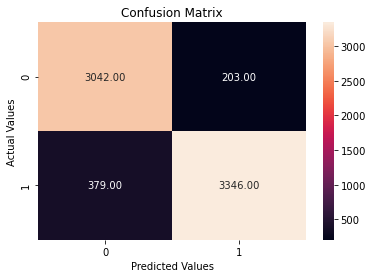

In [118]:
print("Support Vector Machine")
print(accuracy_score(y_test_label_tfidf, base_model_predicted_tfidf))
print(classification_report(y_test_label_tfidf, base_model_predicted_tfidf))

base_cm_tfidf = confusion_matrix(y_test_label_tfidf, base_model_predicted_tfidf)
sns.heatmap(base_cm_tfidf, annot=True, fmt = '.2f')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [112]:
# need to fine tune the base model to get better results 
# by adjusting the regularization C value, it can be seen it improves the accuracy of the model
# using grid search to find the best parameter for SVM
  
# set the range for parameters
parameter_gs_tfidf = {'C': [0.01, 0.1, 1, 10, 100, 1000], 
              'kernel': ['linear']} 
  
gs_tfidf = GridSearchCV(svm.SVC(), parameter_gs_tfidf, refit = True, verbose = 3)
  
# fitting the model for grid search
gs_tfidf.fit(tf_x_train, y_train_label_tfidf)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ..........................C=0.01, kernel=linear; total time= 1.5min
[CV 2/5] END ..........................C=0.01, kernel=linear; total time= 1.5min
[CV 3/5] END ..........................C=0.01, kernel=linear; total time= 1.5min
[CV 4/5] END ..........................C=0.01, kernel=linear; total time= 1.5min
[CV 5/5] END ..........................C=0.01, kernel=linear; total time= 1.4min
[CV 1/5] END ...........................C=0.1, kernel=linear; total time= 1.1min
[CV 2/5] END ...........................C=0.1, kernel=linear; total time= 1.1min
[CV 3/5] END ...........................C=0.1, kernel=linear; total time= 1.1min
[CV 4/5] END ...........................C=0.1, kernel=linear; total time= 1.1min
[CV 5/5] END ...........................C=0.1, kernel=linear; total time= 1.1min
[CV 1/5] END .............................C=1, kernel=linear; total time= 1.6min
[CV 2/5] END .............................C=1, ke

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'kernel': ['linear']},
             verbose=3)

In [113]:
# print best parameter after tuning
print(gs_tfidf.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(gs_tfidf.best_estimator_)

{'C': 1, 'kernel': 'linear'}
SVC(C=1, kernel='linear')


              precision    recall  f1-score   support

           0       0.91      0.93      0.92      3245
           1       0.94      0.92      0.93      3725

    accuracy                           0.92      6970
   macro avg       0.92      0.93      0.92      6970
weighted avg       0.93      0.92      0.92      6970



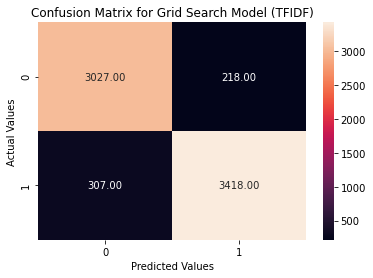

In [120]:
# grid search model (TFIDF)
predictions_gs_tfidf = gs_tfidf.predict(tf_x_test)
  
# print classification report
print(classification_report(y_test_label_tfidf, predictions_gs_tfidf))

# print confusion matrix
gs_cm_tfidf = confusion_matrix(y_test_label_tfidf, predictions_gs_tfidf)
sns.heatmap(gs_cm_tfidf, annot=True, fmt = '.2f')
plt.title('Confusion Matrix for Grid Search Model (TFIDF)')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

              precision    recall  f1-score   support

           0       0.89      0.94      0.91      3245
           1       0.94      0.90      0.92      3725

    accuracy                           0.92      6970
   macro avg       0.92      0.92      0.92      6970
weighted avg       0.92      0.92      0.92      6970



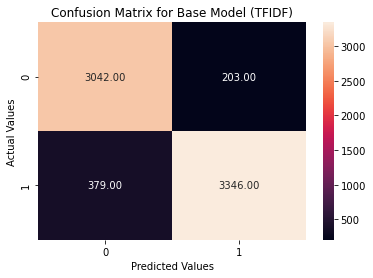

In [127]:
# baseline model (TFIDF)

# print classification report
print(classification_report(y_test_label_tfidf, base_model_predicted_tfidf))

# print confusion matrix
sns.heatmap(base_cm_tfidf, annot=True, fmt = '.2f')
plt.title('Confusion Matrix for Base Model (TFIDF)')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

# final model has same accuracy, lower FN, higher TP
# final model performed better than base model

#### Plot ROC Curve for models

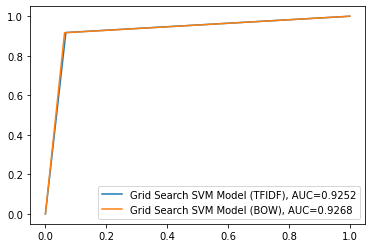

In [128]:
#set up plotting area
plt.figure(0).clf()

# plot ROC curve for Grid Search SVM Model(TFIDF)
fpr_tfidf, tpr_tfidf, _ = metrics.roc_curve(y_test_label_tfidf, predictions_gs_tfidf)
auc = round(metrics.roc_auc_score(y_test_label_tfidf, predictions_gs_tfidf), 4)
plt.plot(fpr_tfidf,tpr_tfidf,label="Grid Search SVM Model (TFIDF), AUC="+str(auc))

# plot ROC curve for Grid Search SVM Model(BOW)
fpr_bow, tpr_bow, _ = metrics.roc_curve(y_test_label_bow, predictions_gs_bow)
auc = round(metrics.roc_auc_score(y_test_label_bow, predictions_gs_bow), 4)
plt.plot(fpr_bow,tpr_bow,label="Grid Search SVM Model (BOW), AUC="+str(auc))

#add legend
plt.legend()

# svm with bow has higher AUC score than svm with tfidf so it means it is better at differentiating both classes

#### Build Final Model

In [152]:
# BOW
print("Bag of Words……")

from sklearn.feature_extraction.text import CountVectorizer

my_stopWords = stop_words
count_vectorizer = CountVectorizer(stop_words= my_stopWords)
bow_vector_final = count_vectorizer.fit(x_train)
bow_x_train_final = count_vectorizer.transform(x_train)

bow_x_test_final = count_vectorizer.transform(x_test)

Bag of Words……


In [153]:
# after evaluation, final model is chosen
# rmb to write bow / tfidf for fit and predicted

final_model = svm.SVC(C=0.1, kernel='linear', random_state = 42, probability=True)
final_model = sklearn.base.clone(final_model)

final_model.fit(bow_x_train_final, y_train_label)
final_model_predicted = final_model.predict(bow_x_test_final)

Support Vector Machine
0.9261119081779053
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      3245
           1       0.94      0.92      0.93      3725

    accuracy                           0.93      6970
   macro avg       0.93      0.93      0.93      6970
weighted avg       0.93      0.93      0.93      6970



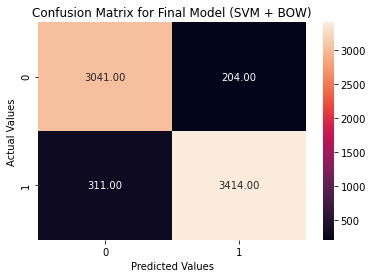

In [154]:
# print classification report
print("Support Vector Machine")
print(accuracy_score(y_test_label, final_model_predicted))
print(classification_report(y_test_label, final_model_predicted))

# print confusion matrix 
final_cm = confusion_matrix(y_test_label, final_model_predicted)
sns.heatmap(final_cm, annot=True, fmt = '.2f')
plt.title('Confusion Matrix for Final Model (SVM + BOW)')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

#### Further Evaluation on the Final Model and Base Model

In [193]:
# calculate Cohen Kappa score and Matthews Correlation Coefficient (MCC)
# since accuracy of model is high, so this was used to check if it is performing well 
# if value is close to 1, this classifier is performing well 

from sklearn.metrics import cohen_kappa_score
ckappa_score = cohen_kappa_score(y_test_label, final_model_predicted)
print("Kappa score for base model : ", round(ckappa_score_base_bow, 4))
print("Kappa score for final model : ", round(ckappa_score,4))

print('\n')
from sklearn.metrics import matthews_corrcoef
mcc_score = matthews_corrcoef(y_test_label, final_model_predicted)
print("MCC score for base model : ", round(mcc_score_base_bow,4))
print("MCC score for final model : ", round(mcc_score,4))

Kappa score for base model :  0.8194
Kappa score for final model :  0.8518


MCC score for base model :  0.8207
MCC score for final model :  0.8522


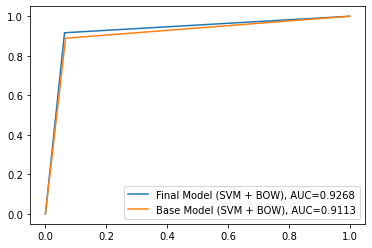

In [164]:
# plot ROC curve for Final Model(SVM + BOW) to compare with base model

plt.figure(0).clf()
fpr, tpr, _ = metrics.roc_curve(y_test_label, final_model_predicted)
auc = round(metrics.roc_auc_score(y_test_label, final_model_predicted), 4)
plt.plot(fpr,tpr,label="Final Model (SVM + BOW), AUC="+str(auc))

fpr, tpr, _ = metrics.roc_curve(y_test_label_bow, base_model_predicted)
auc = round(metrics.roc_auc_score(y_test_label_bow, base_model_predicted), 4)
plt.plot(fpr,tpr,label="Base Model (SVM + BOW), AUC="+str(auc))

plt.legend()

# auc score of final model is better than base model 

In [158]:
# Precision vs Recall Graph for training data 

# retrieve the average cross-validated prediction score values for all samples 
final_model_score_cv = cross_val_predict(final_model, bow_x_test_final, y_test_label, cv = 3, method = "decision_function")
final_model_score_cv

array([-1.30074433, -1.42144433,  0.72656642, ...,  0.01447615,
       -0.45203581, -0.72255481])

<Figure size 432x288 with 0 Axes>

<Figure size 576x432 with 0 Axes>

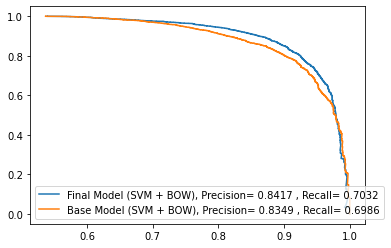

In [186]:
final_model_precision, final_model_recall, final_model_threhold = precision_recall_curve(
                                                                            y_test_label, final_model_score_cv)

precision = round(np.mean(final_model_precision),4)
recall = round(np.mean(final_model_recall),4)
threshold = round(np.mean(final_model_threhold),4)

plt.figure(0).clf()
plt.figure(figsize=(8, 6))
plt.show()
plt.plot(final_model_precision, final_model_recall ,
         label="Final Model (SVM + BOW), Precision= {} , Recall= {}".format(str(precision), str(recall)))

plt.plot(base_model_bow_precision, base_model_bow_recall ,
         label="Base Model (SVM + BOW), Precision= {} , Recall= {}".format(str(precision_base), str(recall_base)))
plt.legend()

# final model has better precision and recall after fine tuning 

In [185]:
# threshold value for models 

print("Threshold of Base Model: ",threshold_base)
print("Threshold of Final Model: ", threshold)

Threshold of Base Model:  0.1202
Threshold of Final Model:  0.2373
